Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 130, 96)           42240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 88,266
Trainable params: 88,266
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


2022-05-14 14:06:39.488822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


92/92 [==============================] - 9s 72ms/step - loss: 2.1749 - accuracy: 0.2175 - val_loss: 1.7752 - val_accuracy: 0.4399
Epoch 2/30
92/92 [==============================] - 6s 66ms/step - loss: 1.7075 - accuracy: 0.3850 - val_loss: 1.3667 - val_accuracy: 0.5546
Epoch 3/30
92/92 [==============================] - 6s 66ms/step - loss: 1.3759 - accuracy: 0.4776 - val_loss: 1.1040 - val_accuracy: 0.6052
Epoch 4/30
92/92 [==============================] - 6s 66ms/step - loss: 1.1388 - accuracy: 0.5810 - val_loss: 0.9500 - val_accuracy: 0.6667
Epoch 5/30
92/92 [==============================] - 7s 76ms/step - loss: 0.9787 - accuracy: 0.6323 - val_loss: 0.8409 - val_accuracy: 0.6981
Epoch 6/30
92/92 [==============================] - 7s 80ms/step - loss: 0.8677 - accuracy: 0.6844 - val_loss: 0.7533 - val_accuracy: 0.7240
Epoch 7/30
92/92 [==============================] - 8s 91ms/step - loss: 0.7660 - accuracy: 0.7243 - val_loss: 0.7245 - val_accuracy: 0.7459
Epoch 8/30
92/92 [======

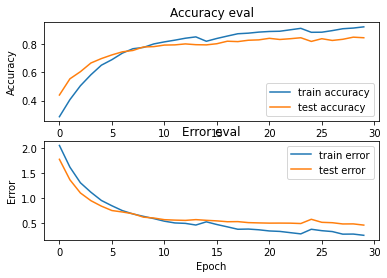

39/39 - 1s - loss: 0.5616 - accuracy: 0.8172

Test accuracy: 0.8172131180763245


In [5]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data_10segment.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(96, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [15]:
import json
import os
import math
import librosa

DATASET_PATH = "data/test_data/greenday/greenday3.wav"
JSON_PATH = "data_test2.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    signal, sample_rate = librosa.load(dataset_path, sr=SAMPLE_RATE)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
           
    return data

    # save MFCCs to json file
#     with open(json_path, "w") as fp:
#         json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    MFCC = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [16]:
X = np.array(MFCC["mfcc"])
X.shape

(9, 130, 13)

In [17]:
prediction = model.predict(X)

map = {0:"brunomars",
       1: "greenday",
       2:  "Migos",
       3:  "Beyonce",
       4:  "maroon5",
      -1: "Great Voice! But I don't know. New Artist."}
# get index with max value
# print(prediction)
predicted_index = []
for row in prediction:
    maxm_pb = max(row)
    if maxm_pb>0.5:
        predicted_index.extend(np.where(row==maxm_pb)[0])
    else:
        predicted_index.append(-1)
    
# predicted_index = np.argmax(prediction, axis=1)
print(predicted_index)
import statistics as st
print("Predicted label: {}".format(map[st.mode(predicted_index)]))

[1, 1, 1, 4, 3, 1, 4, 1, 1]
Predicted label: greenday
